# Drift Simulator

## User Specifications

In [1]:
### User can change these variables (unless they begin with an underscore) ###

drift_model = 'turnbull'  # must be 'turnbull' or 'wagner'
ocean_model = 'ecmwf'  # must be 'ecmwf'
atm_model = 'ecmwf'  # must be 'ecmwf'

iip_season = 2015  # must be 2015 (more to come later)
iip_indices = range(3284, 3286)  # iip_indices must be list or range

## Imports

In [2]:
from datetime import timedelta
import numpy as np
import netCDF4 as nc

In [3]:
if drift_model == 'turnbull':
    from icedef.turnbull import drift
elif drift_model == 'wagner':
    from icedef.wagner import drift
else:
    print('drift model specified is invalid')
    
from icedef import iceberg, metocean, plot

## Iceberg Data

In [4]:
iip_df = iceberg.add_datetime_column(iceberg.get_iip_df(iip_season))
iip_berg_df = iceberg.get_iip_berg_df(iip_df, indices=iip_indices)
iip_berg_df

,index,ICEBERG_YEAR,ICEBERG_NUMBER,SIGHTING_DATE,SIGHTING_TIME,SIGHTING_LATITUDE,SIGHTING_LONGITUDE,SIGHTING_METHOD,SIZE,SHAPE,SOURCE,TIMESTAMP
0,3284,2015,20668,6/17/2015,1043,48.16,-50.16,R/V,LG,GEN,GMRS,2015-06-17 10:43:00
1,3285,2015,20668,6/18/2015,1251,48.17,-49.91,VIS,LG,TAB,GTJZ,2015-06-18 12:51:00


In [5]:
iip_berg = iceberg.get_iip_berg(iip_berg_df)

## Metocean Data

In [6]:
ocean_data = metocean.ECMWF_Ocean(min(iip_berg.history['X']), max(iip_berg.history['X']),
                         min(iip_berg.history['Y']), max(iip_berg.history['Y']),
                         iip_berg.history['T'][0], iip_berg.history['T'][-1])

ocean_data.filenames

['20150617.nc', '20150618.nc']

In [7]:
atm_data = metocean.ECMWF_Atm(min(iip_berg.history['X']), max(iip_berg.history['X']),
                         min(iip_berg.history['Y']), max(iip_berg.history['Y']),
                         iip_berg.history['T'][0], iip_berg.history['T'][-1])

atm_data.filenames

['20150617.nc', '20150618.nc']

## Simulate Drift

In [128]:
vary_currents = True
vary_winds = True
vary_drag_coeffs = True
vary_berg_dims = True
vary_berg_initial_vels = True



# Timesteps
t_step_hours = 0.5

t0 = iip_berg.history['T'][0]
tf = iip_berg.history['T'][-1]
t_delta = tf - t0
t_delta_hours = t_delta.days*24 + t_delta.seconds/3600
t_step = timedelta(hours = t_step_hours)
dt = t_step_hours*3600  # timestep in seconds
t_all = []

for i in np.arange(0, t_delta_hours + t_step_hours, t_step_hours):
    new_date = t0 + timedelta(hours=i)
    t_all.append(new_date)

    
    

# Current and wind subsets
UW_data_subset = metocean.get_data_subset(ocean_data.UW, ocean_data.xy_res, ocean_data.lats, ocean_data.lons, 
            min(iip_berg.history['Y']), max(iip_berg.history['Y']), 
            min(iip_berg.history['X']), max(iip_berg.history['X']))
VW_data_subset = metocean.get_data_subset(ocean_data.VW, ocean_data.xy_res, ocean_data.lats, ocean_data.lons, 
                min(iip_berg.history['Y']), max(iip_berg.history['Y']), 
                min(iip_berg.history['X']), max(iip_berg.history['X']))

UA_data_subset = metocean.get_data_subset(atm_data.UA, atm_data.xy_res, atm_data.lats, atm_data.lons, 
                min(iip_berg.history['Y']), max(iip_berg.history['Y']), 
                min(iip_berg.history['X']), max(iip_berg.history['X']))
VA_data_subset = metocean.get_data_subset(atm_data.VA, atm_data.xy_res, atm_data.lats, atm_data.lons, 
                min(iip_berg.history['Y']), max(iip_berg.history['Y']), 
                min(iip_berg.history['X']), max(iip_berg.history['X']))


    

    
num_runs = 10  
mod_berg_list = []

for run_num in range(num_runs):
    
    # Current and wind variations
    if vary_currents:

        UW_offset = metocean.get_current_offset(UW_data_subset)
        VW_offset = metocean.get_current_offset(VW_data_subset)

    if vary_winds:

        UA_offset = metocean.get_wind_offset(UA_data_subset)
        VA_offset = metocean.get_wind_offset(VA_data_subset)



    # Model iceberg
    mod_berg = iceberg.clone_iceberg_state(iip_berg)

    if vary_drag_coeffs:
        mod_berg.vary_drag_coeffs()

    if vary_berg_dims:
        mod_berg.vary_berg_dims()

    if vary_berg_initial_vels:
        # Iceberg travels at roughly 2% of the wind speed (rule of thumb)
        UA_mean = metocean.get_data_stats(UA_data_subset)[0]
        mod_berg.Vx = 0.02*UA_mean
        VA_mean = metocean.get_data_stats(VA_data_subset)[0]
        mod_berg.Vy = 0.02*VA_mean



    # Constants
    earth_radius = 6378*1e3  # radius of Earth  (m)


    # Buffer number for bounding spatial box
    drift_xmin = max(min(ocean_data.lons), min(atm_data.lons))
    drift_xmax = min(max(ocean_data.lons), max(atm_data.lons))
    drift_ymin = max(min(ocean_data.lats), min(atm_data.lats))
    drift_ymax = min(max(ocean_data.lats), max(atm_data.lats))


    for t in t_all:

        mod_berg.T = t

        # Wind and ocean current velocities
        T_ocean = nc.date2num(mod_berg.T, ocean_data.t_units, ocean_data.t_calendar)
        T_atm = nc.date2num(mod_berg.T, atm_data.t_units, atm_data.t_calendar)
        Vcx = ocean_data.iUW([T_ocean, mod_berg.Y, mod_berg.X])[0]  # u-component of ocean current velocity (m/s)
        Vcy = ocean_data.iVW([T_ocean, mod_berg.Y, mod_berg.X])[0]  # v-component of ocean current velocity (m/s)
        Vax = atm_data.iUA([T_atm, mod_berg.Y, mod_berg.X])[0]  # u-component of air velocity (m/s)
        Vay = atm_data.iVA([T_atm, mod_berg.Y, mod_berg.X])[0]  # v-component of air velocity (m/s)

        Vcx += UW_offset
        Vcy += VW_offset
        Vax += UA_offset
        Vay += VA_offset

        # Drift
        mod_berg.Vx, mod_berg.Vy = drift(mod_berg, Vax, Vay, Vcx, Vcy, dt)

        # Iceberg position (note the conversion from meters back to degrees)
        y_ = mod_berg.Y
        # y-component of iceberg position (degrees latitude)
        mod_berg.Y += dt*mod_berg.Vy*(180/(np.pi*earth_radius))
        # x-component of iceberg position (degrees longitude)
        mod_berg.X += dt*mod_berg.Vx/(np.cos((((y_ + mod_berg.Y)/2)*np.pi)/180))*(180/(np.pi*earth_radius))

        if not drift_xmin < mod_berg.X < drift_xmax:
            print('Iceberg out-of-bounds')
            break

        elif not drift_ymin < mod_berg.Y < drift_ymax:
            print('Iceberg out-of-bounds')
            break

        else:
            mod_berg.history['T'].append(mod_berg.T)
            mod_berg.history['X'].append(mod_berg.X)
            mod_berg.history['Y'].append(mod_berg.Y)
            mod_berg.history['Vx'].append(mod_berg.Vx)
            mod_berg.history['Vy'].append(mod_berg.Vy)

    print("Final time: {}".format(t)) 
    mod_berg_list.append(mod_berg)

Final time: 2015-06-18 13:13:00
Final time: 2015-06-18 13:13:00
Final time: 2015-06-18 13:13:00
Final time: 2015-06-18 13:13:00
Final time: 2015-06-18 13:13:00
Final time: 2015-06-18 13:13:00
Final time: 2015-06-18 13:13:00
Final time: 2015-06-18 13:13:00
Final time: 2015-06-18 13:13:00
Final time: 2015-06-18 13:13:00


## Plotting

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
from mpl_toolkits.basemap import Basemap

In [176]:
def find_matching_value_indices(small_list, big_list):
    """This function finds the indices from one list of the values that match the values from the other list.
    
    Args:
        small_list (list of float or int): 1D list of numbers, smaller in length than big_list
        big_list (list of float or int): 1D list of evenly spaced numbers, larger in length than small_list
        
    Returns:
        matching_indices (list of int): list of all the indices of the bigger list which match the smaller list values
        
    """
    
    big_delta = big_list[1] - big_list[0]
    
    matching_indices = []
    
    for small_item in small_list:
        for big_index, big_item in enumerate(big_list):
            delta = abs(small_item - big_item)
            if delta < big_delta:
                matching_index = big_index
                matching_indices.append(matching_index)
                break
    
    return matching_indices



def plot_drift_track_test_case(iip_berg, mod_berg, time_labels=True):
    """This function plots the drift track of a simulated iceberg against its observed coordinates"
    
    Args:
        iip_berg (Iceberg): all attributes correspond to data from a particular IIP iceberg.
        mod_berg (Iceberg): initial attributes and final time correspond to data from a particular 
                            IIP iceberg but the rest comes from drift simulation.  
    """
    
    fig, ax = plt.subplots(dpi=150)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Comparison of Drift Model Track to IIP Observations')
    ax.xaxis.labelpad = 60
    ax.yaxis.labelpad = 60
    
    iip_lons = iip_berg.history['X']
    iip_lats = iip_berg.history['Y']
    mod_lons = mod_berg.history['X']
    mod_lats = mod_berg.history['Y']
    
    # Get min and max iceberg lons and lats for defining the plot axes ranges
    berg_xmin = min(min(mod_lons), min(iip_lons)) 
    berg_xmax = max(max(mod_lons), max(iip_lons))
    berg_ymin = min(min(mod_lats), min(iip_lats))
    berg_ymax = max(max(mod_lats), max(iip_lats))

    # spatial buffer for expanding the plot axes ranges for better readability
    buff = 0.1
    
    # instantiate Basemap object with mercator projection
    m = Basemap(projection='merc', lat_0 = 57, lon_0 = -135,
                resolution = 'l', area_thresh = 0.1,
                llcrnrlon = berg_xmin - buff, 
                llcrnrlat = berg_ymin - buff,
                urcrnrlon = berg_xmax + buff, 
                urcrnrlat = berg_ymax + buff)
    
    # parallels are lines of latitude, meridians are lines of longitude 
    parallels = np.arange(berg_ymin, berg_ymax + buff, buff)
    meridians = np.arange(berg_xmin, berg_xmax + buff, buff)

    # labels = [left,right,top,bottom]
    m.drawparallels(parallels,labels=[True,False,False,False])
    mers = m.drawmeridians(meridians,labels=[False,False,False,True])
    for mer in mers:
        try:
            mers[mer][1][0].set_rotation(90)
        except:
            pass

    # make the land pretty
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color = 'coral')
    m.drawmapboundary()

    # map lons and lats to x and y in meters
    iip_x, iip_y = m(iip_lons, iip_lats)
    mod_x, mod_y = m(mod_lons, mod_lats)

    # scatter both sets of data points so timesteps can be seen
    ax.scatter(iip_x, iip_y, marker='o', s=10, c='black')
    ax.scatter(mod_x, mod_y, marker='o', s=1, c='red')
    
    # if True, annotate matching points in time between datasets
    if time_labels:
        
        iip_times = iip_berg.history['T']
        mod_times = mod_berg.history['T']

        matching_indices = find_matching_value_indices(iip_times, mod_times)
        
        iip_hours = [(t-iip_times[0]).days*24 + (t-iip_times[0]).seconds/3600 for t in iip_times]
        hour_labels = [str(round(x, 1)) for x in iip_hours]

        for i, hour_label in enumerate(hour_labels):
            j = matching_indices[i]
            ax.scatter(iip_x[i], iip_y[i], marker='X', color='black')
            ax.text(iip_x[i], iip_y[i], hour_label)
            if not round(iip_lons[i], 2) == round(mod_lons[j], 2):
                ax.scatter(mod_x[j], mod_y[j], marker='X', color='red')
                ax.text(mod_x[j], mod_y[j], hour_label)
        
    return fig

In [174]:
def plot_spaghetti_test_case(iip_berg, mod_berg_list, time_labels=False):
    
    fig, ax = plt.subplots(dpi=150)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Comparison of Drift Model Tracks to IIP Observations')
    ax.xaxis.labelpad = 60
    ax.yaxis.labelpad = 60
    
    iip_lons = iip_berg.history['X']
    iip_lats = iip_berg.history['Y']
    
    berg_xmin, berg_xmax = min(iip_lons), max(iip_lons)
    berg_ymin, berg_ymax = min(iip_lats), max(iip_lats)
    
    for mod_berg in mod_berg_list:
        
        mod_lons = mod_berg.history['X']
        mod_lats = mod_berg.history['Y']
    
        # Get min and max iceberg lons and lats for defining the plot axes ranges
        tmp_xmin = min(min(mod_lons), min(iip_lons)) 
        tmp_xmax = max(max(mod_lons), max(iip_lons))
        tmp_ymin = min(min(mod_lats), min(iip_lats))
        tmp_ymax = max(max(mod_lats), max(iip_lats))
        
        berg_xmin = min(berg_xmin, tmp_xmin)
        berg_xmax = max(berg_xmax, tmp_xmax)
        berg_ymin = min(berg_ymin, tmp_ymin)
        berg_ymax = max(berg_ymax, tmp_ymax)

    
    # spatial buffer for expanding the plot axes ranges for better readability
    buff = 0.1
    
    # instantiate Basemap object with mercator projection
    m = Basemap(projection='merc', lat_0 = 57, lon_0 = -135,
                resolution = 'l', area_thresh = 0.1,
                llcrnrlon = berg_xmin - buff, 
                llcrnrlat = berg_ymin - buff,
                urcrnrlon = berg_xmax + buff, 
                urcrnrlat = berg_ymax + buff)
    
    # parallels are lines of latitude, meridians are lines of longitude 
    parallels = np.round(np.arange(berg_ymin, berg_ymax + buff, buff), 2)
    meridians = np.round(np.arange(berg_xmin, berg_xmax + buff, buff), 2)

    # labels = [left,right,top,bottom]
    m.drawparallels(parallels,labels=[True,False,False,False])
    mers = m.drawmeridians(meridians,labels=[False,False,False,True])
    for mer in mers:
        try:
            mers[mer][1][0].set_rotation(90)
        except:
            pass
    
    
    # make the land pretty
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color = 'coral')
    m.drawmapboundary()

    # map lons and lats to x and y in meters
    iip_x, iip_y = m(iip_lons, iip_lats)
 
    # get lists of iip times for comparing to mod times to later annotate plot with labels
    iip_times = iip_berg.history['T']
    iip_hours = [(t-iip_times[0]).days*24 + (t-iip_times[0]).seconds/3600 for t in iip_times]
    hour_labels = [str(round(x, 1)) for x in iip_hours]


    for i, hour_label in enumerate(hour_labels):
        ax.scatter(iip_x[i], iip_y[i], marker='X', color='black')
        ax.text(iip_x[i], iip_y[i], hour_label)
        
    
    for mod_berg in mod_berg_list:
        mod_lons = mod_berg.history['X']
        mod_lats = mod_berg.history['Y']
        mod_x, mod_y = m(mod_lons, mod_lats)
        ax.scatter(mod_x, mod_y, marker='o', s=1)#, c='red')
        
        mod_times = mod_berg.history['T']

        matching_indices = find_matching_value_indices(iip_times, mod_times)
            
        for i, hour_label in enumerate(hour_labels):
            j = matching_indices[i]
            if not round(iip_lons[i], 2) == round(mod_lons[j], 2):
                ax.scatter(mod_x[j], mod_y[j], marker='X', color='red')
                if time_labels:
                    ax.text(mod_x[j], mod_y[j], hour_label)
                    
                    
    plt.savefig('test_plot.png')
    
    return fig

/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


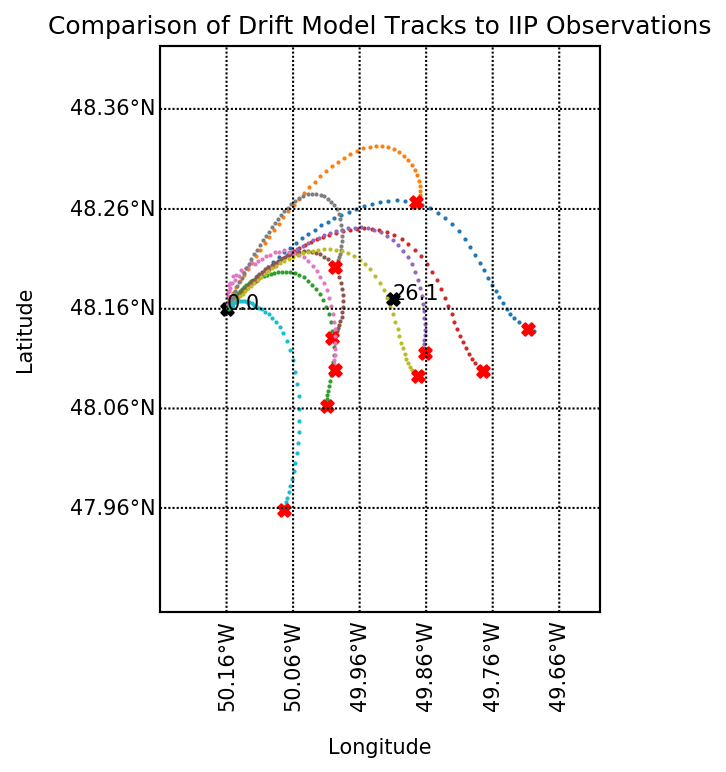

In [172]:
fig = plot_spaghetti_test_case(iip_berg, mod_berg_list)

/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


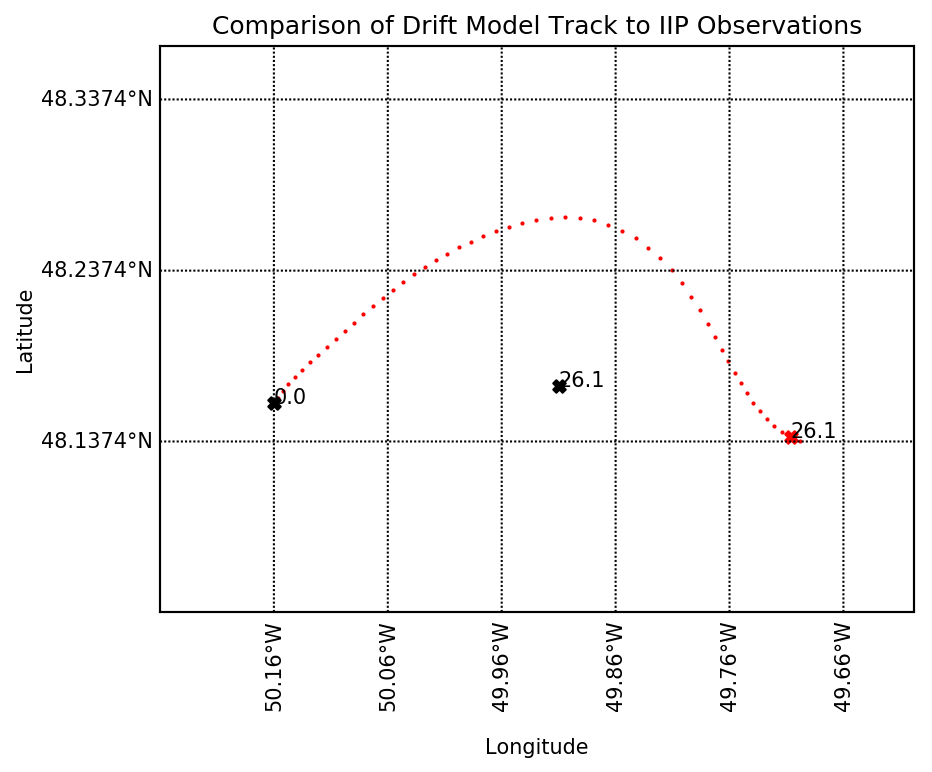

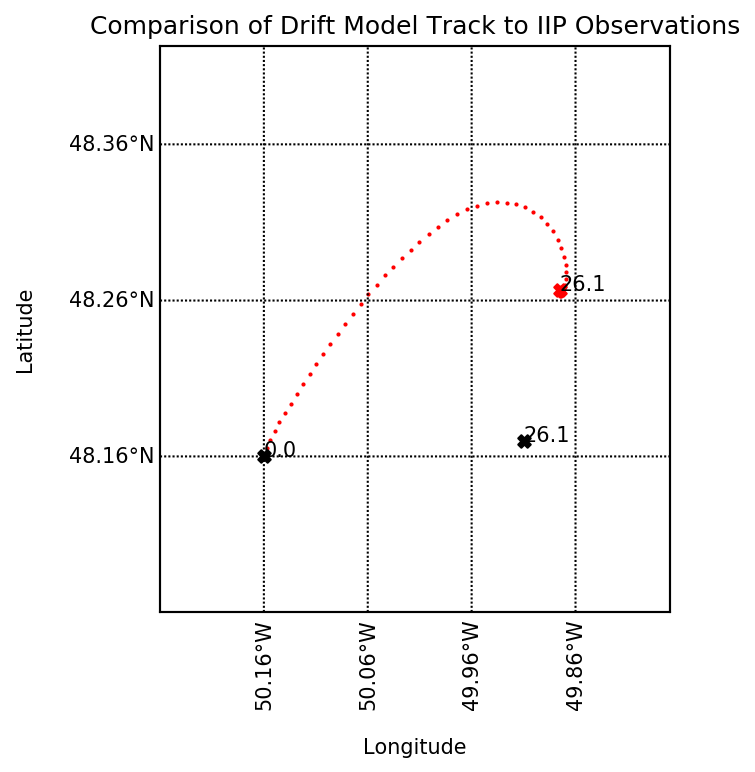

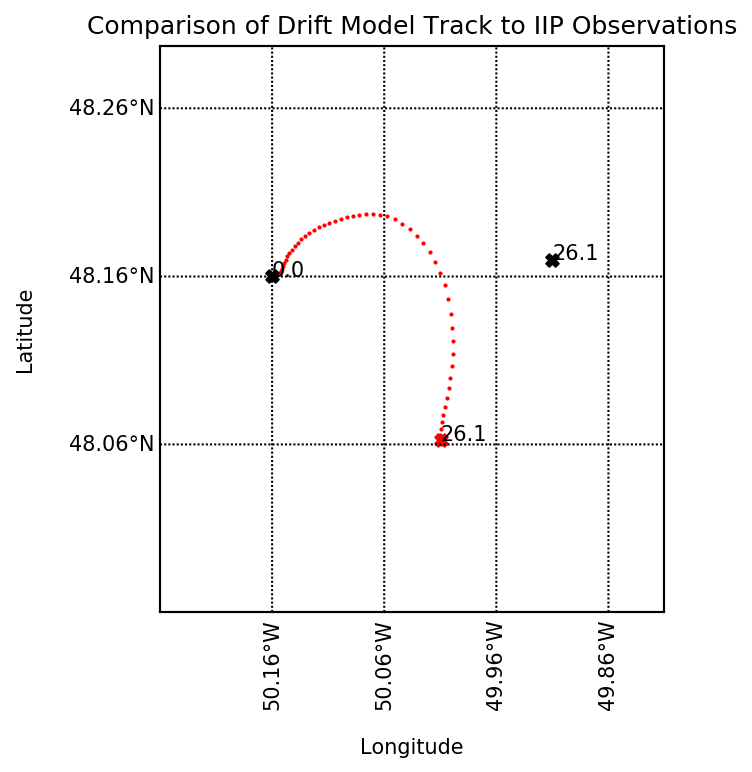

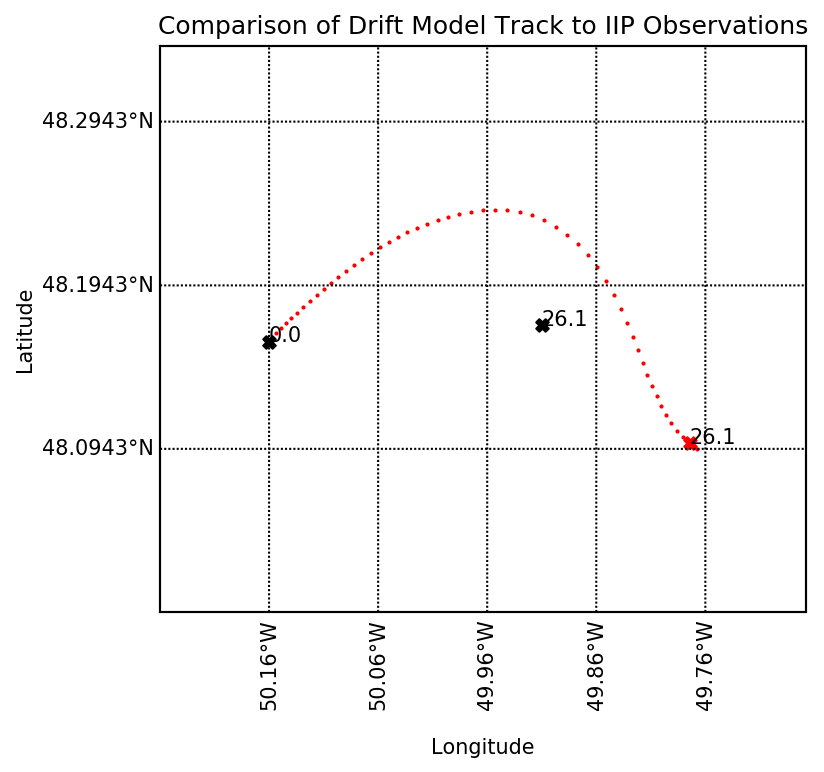

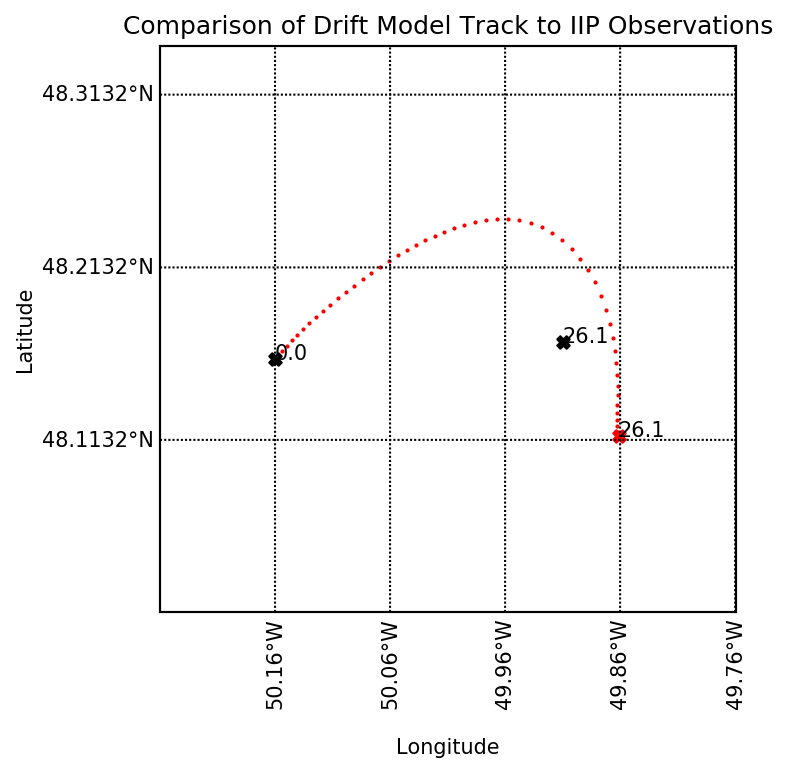

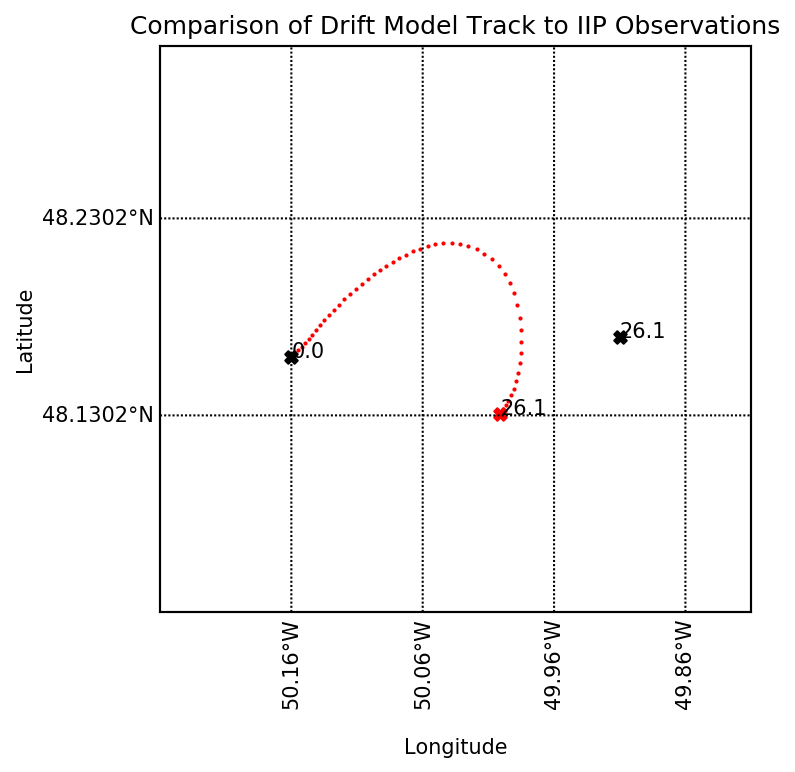

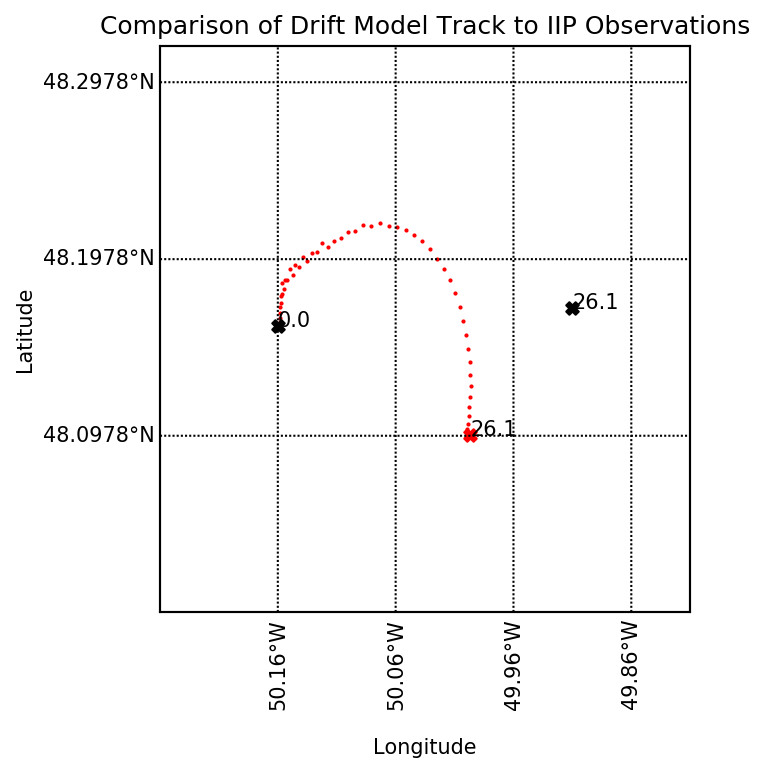

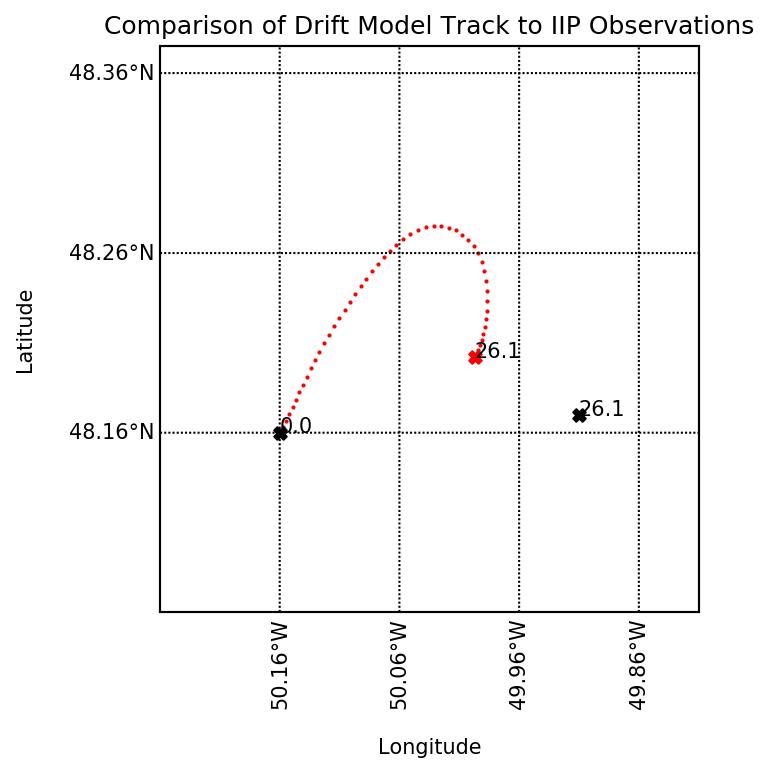

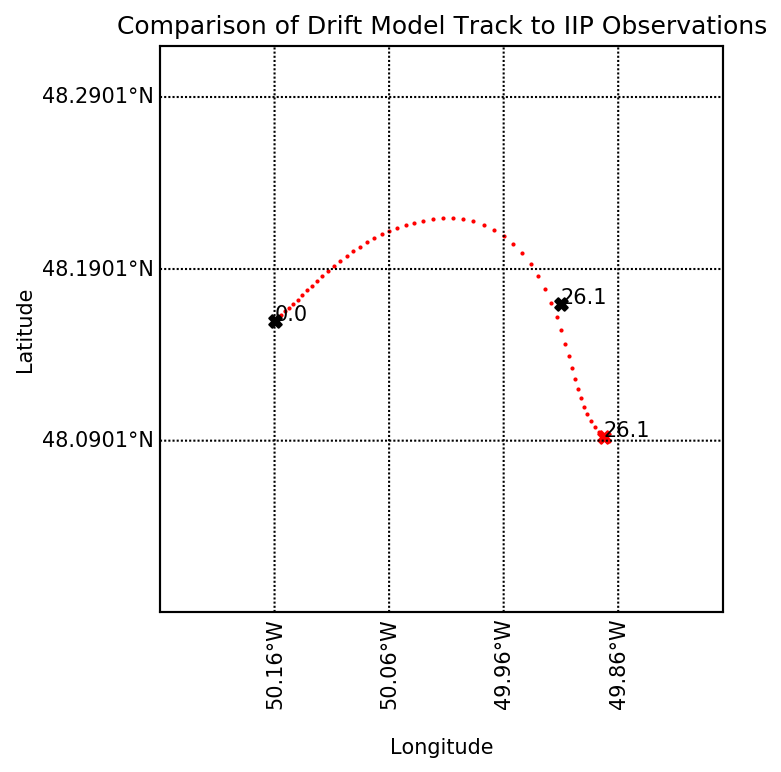

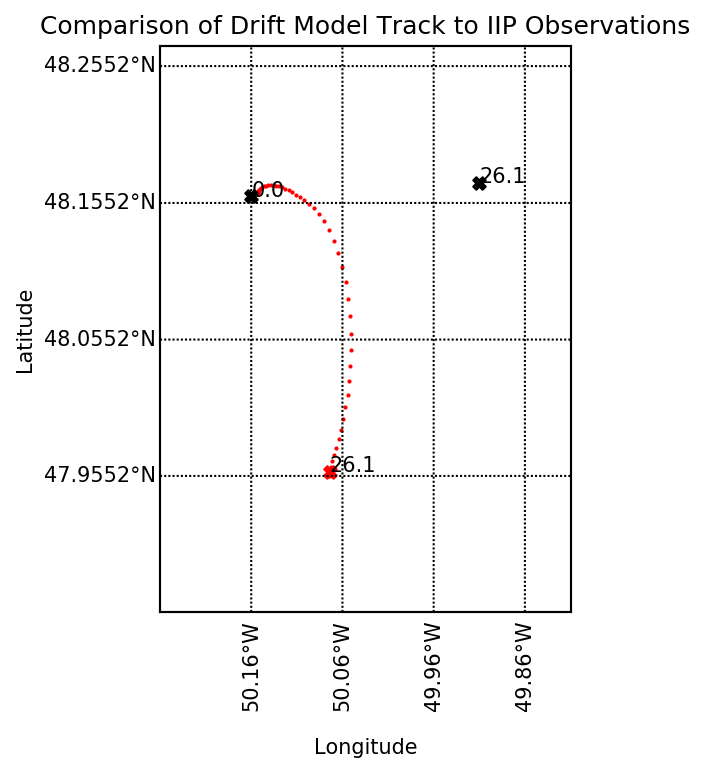

In [177]:
for mod_berg in mod_berg_list:
    fig = plot_drift_track_test_case(iip_berg, mod_berg)